In [ ]:
%%time 
# run if in colab
%rm -r Text-level-GCN/
!git clone https://github.com/VirtualRoyalty/Text-level-GCN.git

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !pip install networkx==1.1

In [4]:
import os
import gc
import sys
import importlib as imp
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
sys.path.append('..')
sys.path.append('Text-level-GCN')

In [5]:
prefix_path = 'Text-level-GCN'
# prefix_path = '..'

In [ ]:
# !pip install -r "../requirements.txt"
!pip install -r "Text-level-GCN/requirements.txt"

In [23]:
# with open('../.secret.env', 'r') as f:
#     secret = f.readlines()
#     secret = [pair.split() for pair in secret]
#     for pair in secret:
#         os.environ[pair[0]] = pair[1]

# 1. Data Loading

In [76]:
NAME = '20ng'
X_train_df = pd.read_csv('%s/data/%s/clean/%s_train.csv' % (prefix_path, NAME, NAME))
X_train_df = X_train_df[X_train_df.columns[-4:]]
X_test_df = pd.read_csv('%s/data/%s/clean/%s_test.csv' % (prefix_path, NAME, NAME))
X_test_df = X_test_df[X_test_df.columns[-4:]]

len(X_train_df), len(X_test_df)

(6532, 2568)

# 2. Data preprocessing

## 2.1 Preprocess text 
```already DONE```

In [77]:
import preprocess.text as ptext
ptext = imp.reload(ptext)

text_preprocessor = ptext.CorpusProcessor()

# X_train_df = text_preprocessor.preprocess(df=X_train_df)
# X_test_df = text_preprocessor.preprocess(df=X_test_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [78]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')


X_train_df['clean_text'] = X_train_df['clean_text'].astype('str')
X_train_df['tokens'] = X_train_df['clean_text'].apply(lambda x: word_tokenize(x))


X_test_df['clean_text'] = X_test_df['clean_text'].astype('str')
X_test_df['tokens'] = X_test_df['clean_text'].apply(lambda x: word_tokenize(x) if type(x)==str else [] )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.2. Build vocab

In [79]:
import preprocess.utils as putils
putils = imp.reload(putils)

MIN_TF = 1
MAX_TF = 2500
MASTER_NODE = False


vocab_terms, term2id = putils.build_vocab(X_train_df['tokens'], 
                                          min_tf=MIN_TF, 
                                          max_tf=MAX_TF,
                                          master_node=MASTER_NODE)

print('VOCAB SIZE:', len(vocab_terms))


VOCAB SIZE: 11581


In [ ]:
import preprocess.embedding as pemb 
pemb = imp.reload(pemb)


ftext_path = '/content/drive/MyDrive/VKR/cc.en.64.bin'
glove_path = '/content/drive/MyDrive/VKR/glove.6B.200d.txt'


emb_model = pemb.Glove(weights_path=glove_path)
# emb_model = pemb.FastText(weights_path=ftext_path)

# emb_model.get('hello')

In [ ]:
putils = imp.reload(putils)
pretrained_weights, oov_lst = putils.get_pretrained_weights(emb_model, vocab_terms, oov_weights_init='random')

## 2.2. Build text-network

In [81]:
import networkx as nx
import preprocess.graph as pgraph
pgraph = imp.reload(pgraph)

In [82]:
slen = 40
sample_text = X_train_df['clean_text'].iloc[5].split()[:slen]
print(' '.join(sample_text))

brown forman inc bfd qtr net shr one dlr net mln mln revs mln mln nine mth shr dlrs dlrs net mln mln revs billion mln reuter


In [83]:
win_size = 2
max_nds = 20

G_sample = pgraph.doc2graph(sample_text, 
                            max_nodes=max_nds, 
                            window_size=win_size, 
                            infranodus_weights=False, 
                            is_directed=False)
A = nx.adjacency_matrix(G_sample).todense()

In [84]:
# np.fill_diagonal(A, 1)
# pd.DataFrame(np.around(A, 1), columns=G_sample.nodes, index=G_sample.nodes)

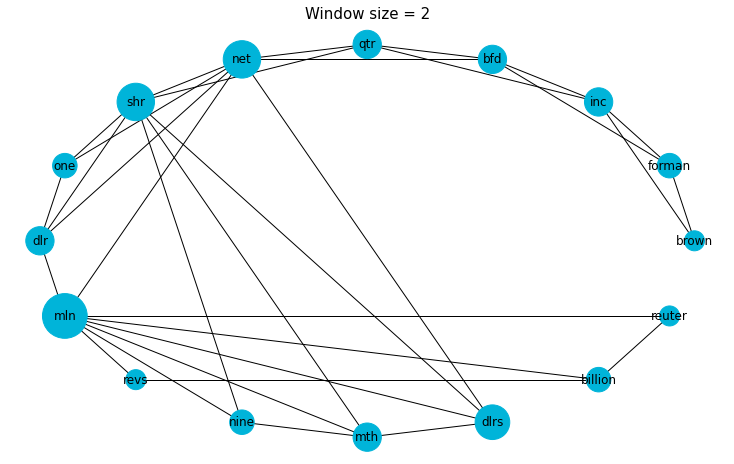

In [85]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
pos = nx.circular_layout(G_sample)
D = dict(G_sample.degree)
nx.draw(G_sample, with_labels=True, pos=pos, node_size=[D[k]*200 for k in D], font_size=12, node_color='#00b4d9')
plt.title('Window size = %d' % win_size, fontsize=15)
pass

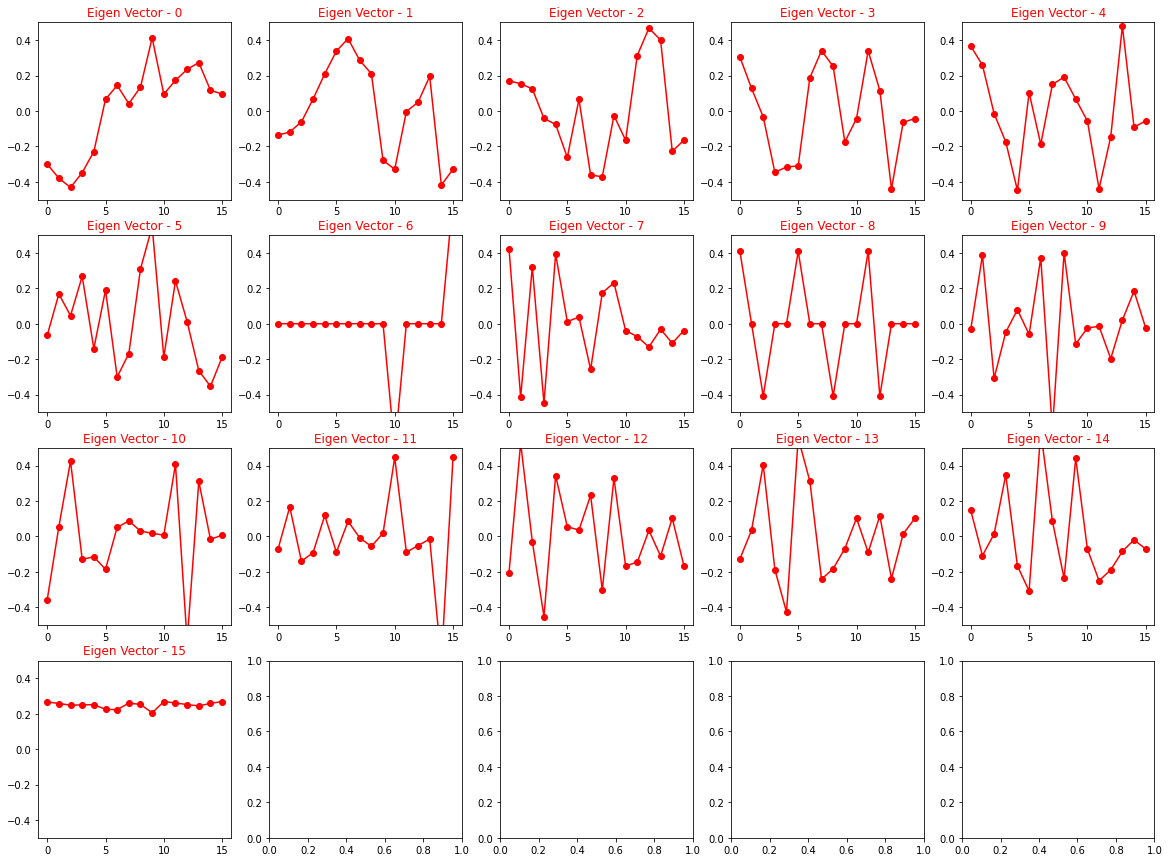

In [86]:
L = np.diag(np.sum(A,axis=1)) - A
b, c = np.linalg.eigh(L)
l = c.shape[0]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=4, ncols=5,figsize=(20, 15))
ax = ax.ravel()
for x in range(l):
    ax[x].plot(range(l),c[:,x],'ro-')
    ax[x].set_title('Eigen Vector - {}'.format(str(x)),c='r')
    ax[x].set_ylim(-0.5,.5)

# 3. Prepare & Train

In [88]:
putils = imp.reload(putils)

MAX_NODES_QUANTILE = 0.98
MAX_NODES = putils.get_max_nodes(X_train_df, term2id, quantile=MAX_NODES_QUANTILE, master_node=MASTER_NODE)
_ = putils.get_max_nodes(X_test_df, term2id, quantile=MAX_NODES_QUANTILE, master_node=MASTER_NODE)
print('MAX NODES:', MAX_NODES)

MAX NODES: 175


In [89]:
X_train_df = X_train_df[X_train_df.n_unique > 1]
X_test_df = X_test_df[X_test_df.n_unique > 1]

In [90]:
len(X_train_df), len(X_test_df)

(6531, 2565)

In [91]:
import preprocess.general as pgeneral
pgeneral = imp.reload(pgeneral)


IS_DIRECTED = False
WINDOW_SIZE = 2

try:
    del X_adj_test
    del X_adj_train
    del X_emb_test
    del X_emb_train
except:
    pass


X_adj_train, X_emb_train, Y_train = pgeneral.get_dataset_from_df(X_train_df, 
                                                                 MAX_NODES,  
                                                                 window_size=WINDOW_SIZE,
                                                                 term2id=term2id,
                                                                 is_directed=IS_DIRECTED
                                                                    # pmi_matrix=pmi_matrix
                                                                    )

X_adj_test, X_emb_test, Y_test = pgeneral.get_dataset_from_df(X_test_df, 
                                                              MAX_NODES,  
                                                              window_size=WINDOW_SIZE,
                                                              term2id=term2id,
                                                              is_directed=IS_DIRECTED
                                                            # pmi_matrix=pmi_matrix
                                                            ) 
gc.collect()

0

In [92]:
from spektral.transforms import GCNFilter, AdjToSpTensor
pgeneral = imp.reload(pgeneral)

train_spektral = pgeneral.CustomDataset(X_emb_train, 
                                        X_adj_train, 
                                        Y_train, 
                                        transforms=[GCNFilter()]) #,  AdjToSpTensor()])
test_spektral = pgeneral.CustomDataset(X_emb_test, 
                                       X_adj_test, 
                                       Y_test,  
                                       transforms=[GCNFilter()])#,  AdjToSpTensor()])
gc.collect()

3116

In [ ]:
import neptune
from neptunecontrib.monitoring.keras import NeptuneMonitor

os.environ['NEPTUNE_API_TOKEN'] = 
neptune.init(api_token=os.environ['NEPTUNE_API_TOKEN'],  project_qualified_name='vmalperovich/VKR')

In [94]:
import tensorflow
import tensorflow as tf
from spektral.data import BatchLoader
import model.gcn as model_gcn

model_gcn = imp.reload(model_gcn)

In [95]:
plot_losses = putils.PlotLosses()
MODEL_TYPE = 'GCN'
NUM_CLASSES =  train_spektral.n_labels
PMI = False
wtype = None #'GloVE'
PRETRAINED = False
# pretrained_weights =None 

params = {
          'MAX_NODES': MAX_NODES,
          'VOCAB_SIZE': len(vocab_terms),
          'EMB_SIZE': 300,
          'NUM_CLASSES': NUM_CLASSES,
          'FIRST_CONV_SIZE': 200,
          'FIRST_CONV_ACTIVATION': 'relu',
          'DROPOUT_RATE': 0.55,
          'L2_RATE': 0.005,
          'LR': 1e-3,
          'LR_FIRST_UPDATE': 5,
          'LR_UPDATE_PER': 10,
          'PRETRAINED': PRETRAINED,
          'PRETRAINED_EMB': wtype,
          'POOLING': 'GlobalSum',
          'WINDOW_SIZE': WINDOW_SIZE,
          'EPOCH': 100,
          'BATCH_SIZE': 32,
          'MASTER_NODE': MASTER_NODE,
          'CONV_TYPE': MODEL_TYPE,
          'BATCH_NORM': False,
          'PMI': PMI,
          'MIN_TF': MIN_TF,
          'MAX_TF': MAX_TF,
          }
print(NAME)
# if MODEL_TYPE == 'MPNN':
#     model = MPNN(**params)
# elif MODEL_TYPE == 'GCN':
#     model = GCN(**params)

model = model_gcn.GCN(#pretrained_weights=pretrained_weights,
                      **params)
params['MODEL_PARAMS'] = model.model.count_params()
params['LAYERS'] = [layer.name for layer in model.model.layers]
params

R52
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Nodes_input (InputLayer)        [(None, 175, 1)]     0                                            
__________________________________________________________________________________________________
Embeddings (Embedding)          (None, 175, 1, 300)  3474300     Nodes_input[0][0]                
__________________________________________________________________________________________________
Reshape (Reshape)               (None, 175, 300)     0           Embeddings[0][0]                 
__________________________________________________________________________________________________
Adj_input (InputLayer)          [(None, 175, 175)]   0                                            
________________________________________________________________________________________

{'BATCH_NORM': False,
 'BATCH_SIZE': 32,
 'CONV_TYPE': 'GCN',
 'DROPOUT_RATE': 0.55,
 'EMB_SIZE': 300,
 'EPOCH': 100,
 'FIRST_CONV_ACTIVATION': 'relu',
 'FIRST_CONV_SIZE': 200,
 'L2_RATE': 0.005,
 'LAYERS': ['Nodes_input',
  'Embeddings',
  'Reshape',
  'Adj_input',
  'Conv',
  'Pooling',
  'Dropout',
  'Dense'],
 'LR': 0.001,
 'LR_FIRST_UPDATE': 5,
 'LR_UPDATE_PER': 10,
 'MASTER_NODE': False,
 'MAX_NODES': 175,
 'MAX_TF': 2500,
 'MIN_TF': 1,
 'MODEL_PARAMS': 3544952,
 'NUM_CLASSES': 52,
 'PMI': False,
 'POOLING': 'GlobalSum',
 'PRETRAINED': False,
 'PRETRAINED_EMB': None,
 'VOCAB_SIZE': 11581,
 'WINDOW_SIZE': 2}

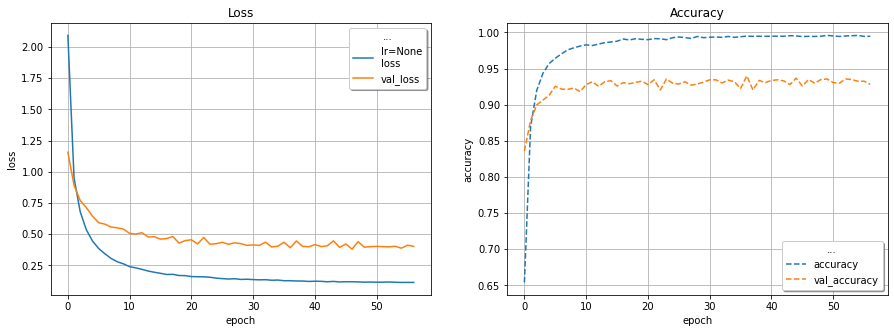

115796

In [96]:
import tensorflow
# neptune.create_experiment(NAME, params=params, tags=['FINAL'])

train_loader = BatchLoader(train_spektral, batch_size=params['BATCH_SIZE'])
test_loader = BatchLoader(test_spektral, batch_size=params['BATCH_SIZE'])
lr_scheduler = tensorflow.keras.callbacks.LearningRateScheduler(model.scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.model.fit(train_loader.load(), 
                    validation_data=test_loader,
                    validation_steps=test_loader.steps_per_epoch,     
                    steps_per_epoch=train_loader.steps_per_epoch, 
                    epochs=params['EPOCH'], 
                    callbacks=[plot_losses, lr_scheduler, early_stop, 
                            #    NeptuneMonitor()
                               ], 
                    verbose=0
          )
# neptune.stop()
gc.collect()

In [ ]:
from sklearn.metrics import f1_score, classification_report


pred = model.model.predict([test_spektral.emb, test_spektral.adj])

print(classification_report(test_spektral.y.numpy().argmax(axis=1).reshape((-1)), pred.argmax(axis=1).reshape((-1))))

In [ ]:
# mb_in_whole_model = X_adj_train.nbytes / (1024*1024) 
# mb_in_whole_model += X_adj_test.nbytes / (1024*1024) 
# mb_in_whole_model += sum([x.nbytes for x in model.model.get_weights()]) / (1024*1024)
# print(round(mb_in_whole_model))

# Explore document embeddings

In [99]:
from tensorflow.keras.models import Model


model_input = model.model.inputs
last_conv = model.model.get_layer(name='Pooling').output
emb_model = Model(inputs=model_input, outputs=last_conv)
node_embs = emb_model.predict(x=[test_spektral.emb, test_spektral.adj])

doc_embeddings = np.array(node_embs)

In [100]:
name2label = X_train_df.groupby(['label_name']).agg({'label':'last'})
name2label = dict(name2label.reset_index().values)
label2name = {v:k for k,v in name2label.items()}
label2name

{0: 'gold',
 1: 'fuel',
 2: 'ship',
 3: 'tea',
 4: 'cotton',
 5: 'lei',
 6: 'coffee',
 7: 'bop',
 8: 'zinc',
 9: 'money-fx',
 10: 'reserves',
 11: 'pet-chem',
 12: 'lead',
 13: 'alum',
 14: 'gnp',
 15: 'dlr',
 16: 'money-supply',
 17: 'sugar',
 18: 'livestock',
 19: 'crude',
 20: 'jet',
 21: 'nat-gas',
 22: 'tin',
 23: 'trade',
 24: 'acq',
 25: 'ipi',
 26: 'heat',
 27: 'orange',
 28: 'iron-steel',
 29: 'earn',
 30: 'strategic-metal',
 31: 'retail',
 32: 'cocoa',
 33: 'rubber',
 34: 'veg-oil',
 35: 'meal-feed',
 36: 'copper',
 37: 'jobs',
 38: 'carcass',
 39: 'interest',
 40: 'platinum',
 41: 'wpi',
 42: 'cpi',
 43: 'nickel',
 44: 'housing',
 45: 'lumber',
 46: 'instal-debt',
 47: 'grain',
 48: 'gas',
 49: 'potato',
 50: 'cpu',
 51: 'income'}

In [101]:
# from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

tsne2 = TSNE(n_components=2).fit_transform(doc_embeddings)
tsne2 = pd.DataFrame(tsne2, columns=['dimension 1', 'dimension 2'])
tsne2['label'] = Y_test.numpy().argmax(axis=1).reshape((-1))
tsne2['label'] = tsne2['label'].apply(lambda x: label2name[x])


# tsne3 = TSNE(n_components=3).fit_transform(doc_embeddings)
# tsne3 = pd.DataFrame(tsne3, columns=['dimension 1', 'dimension 2', 'dimension 3'])
# tsne3['label'] = Y_test.numpy().argmax(axis=1).reshape((-1))
# tsne3['label'] = tsne3['label'].apply(lambda x: label2name[x])

In [72]:
# tsne2['predicted_label'] = pred.argmax(axis=1).reshape((-1))
# tsne2['predicted_label'] = tsne2['predicted_label'].apply(lambda x: label2name[x])
tsne2['label'] = Y_test.numpy().argmax(axis=1).reshape((-1))
# tsne2['label']  = tsne2['label'].astype('str') 
tsne2['label'] = tsne2['label'].apply(lambda x: label2name[x])

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,7))
sns.scatterplot(x='dimension 1', y='dimension 2', hue='label', data=tsne2.sort_values(['label']))
plt.savefig('tsne_R8_label.png')
plt.grid()
pass

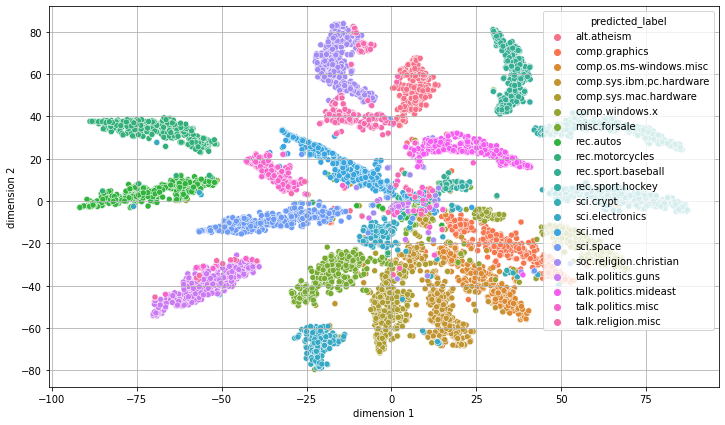

In [67]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='dimension 1', y='dimension 2', hue='predicted_label', data=tsne2.sort_values(['predicted_label']))
plt.grid()
pass

In [ ]:
# import plotly.express as px


# fig = px.scatter_3d(tsne3, 
#                     x='dimension 1', 
#                     y='dimension 2', 
#                     z='dimension 3',
#                     color='label')
# fig.update_traces(marker=dict(size=5,
#                               line=dict(width=2,
#                               color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))
# fig.show()

# Experiments

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from IPython.display import clear_output

import model.gcn as model_gcn
import pipeline.experiment as pexp
from sklearn.model_selection import ParameterGrid

pexp = imp.reload(pexp)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
import neptune
from neptunecontrib.monitoring.keras import NeptuneMonitor

os.environ['NEPTUNE_API_TOKEN'] = 
neptune.init(api_token=os.environ['NEPTUNE_API_TOKEN'],  project_qualified_name='vmalperovich/VKR')

Project(vmalperovich/VKR)

In [9]:
NAME = 'R52'
X_train_df = pd.read_csv('%s/data/%s/clean/%s_train.csv' % (prefix_path, NAME, NAME))
X_train_df = X_train_df[X_train_df.columns[-4:]]
X_test_df = pd.read_csv('%s/data/%s/clean/%s_test.csv' % (prefix_path, NAME, NAME))
X_test_df = X_test_df[X_test_df.columns[-4:]]

print(len(X_train_df), len(X_test_df))

X_train_df['clean_text'] = X_train_df['clean_text'].astype('str')
X_train_df['tokens'] = X_train_df['clean_text'].apply(lambda x: word_tokenize(x))

X_test_df['clean_text'] = X_test_df['clean_text'].astype('str')
X_test_df['tokens'] = X_test_df['clean_text'].apply(lambda x: word_tokenize(x) if type(x)==str else [] )

6532 2568


In [10]:
experiment = pexp.Experiment()

In [11]:
MODEL_TYPE = 'GCN'
PMI = False
wtype = None
MIN_TF = 1
MAX_TF = 2500
# WINDOW_SIZE = 3
MASTER_NODE = False
IS_DIRECTED = False

params = {'WINDOW_SIZE':[170]}
times = 2


for param in ParameterGrid(params):
    print('Params: {}'.format(param))
    for i in range(times):
        print('TIME:', i)

        exp_params = {

                    'EMB_SIZE': 300,
                    'FIRST_CONV_SIZE': 200,
                    'FIRST_CONV_ACTIVATION': 'relu',
                    'DROPOUT_RATE': 0.55,
                    'L2_RATE': 0.005,
                    'LR': 1e-3,
                    'LR_FIRST_UPDATE': 5,
                    'LR_UPDATE_PER': 10,
                    'PRETRAINED': False,
                    'PRETRAINED_EMB': wtype,
                    'POOLING': 'GlobalSum',
                    'WINDOW_SIZE': param['WINDOW_SIZE'],
                    'EPOCH': 100,
                    'BATCH_SIZE': 32,
                    'MASTER_NODE': MASTER_NODE,
                    'CONV_TYPE': MODEL_TYPE,
                    'MODEL_TYPE': MODEL_TYPE,
                    'BATCH_NORM': False,
                    'PMI': PMI,
                    'MIN_TF': MIN_TF,
                    'MAX_TF': MAX_TF,
                    'MAX_NODES_QUANTILE': 0.98,
                    'IS_DIRECTED': IS_DIRECTED
                }

        res_params = experiment.run(ModelClass=model_gcn.GCN,
                                    NAME=NAME, 
                                    tags=['FINAL'],
                                    X_train_df=X_train_df,
                                    X_test_df=X_test_df,
                                    **exp_params)

        clear_output()